<a href="https://colab.research.google.com/github/MariahNicula/SkinCancerDetection-Classification/blob/main/SkinCancerDet%26Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [1]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import anvil.server

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback,EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import  classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

anvil.server.connect("client_ZBSWTBX67R6TUJWI4OHLTM46-P7XQZSMRHDQN4ABN")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as CLIENT


# **Reading the Data**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SkinCancerDet&Class/HAM10000_metadata.csv')
df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [ ]:
df.shape

(10015, 7)

# **Data Preprocessing**

In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = '/content/drive/MyDrive/SkinCancerDet&Class/Dataset2'
!unzip base_skin_dir

unzip:  cannot find or open base_skin_dir, base_skin_dir.zip or base_skin_dir.ZIP.


In [ ]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob.glob(os.path.join(base_skin_dir, '**', '*.jpg'), recursive=True)}


In [ ]:
import glob
paths = glob.glob(os.path.join(base_skin_dir, '*', '*.jpg'))
#print(paths)

In [ ]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/SkinCancerDet&Class/Dat...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/SkinCancerDet&Class/Dat...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/SkinCancerDet&Class/Dat...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/SkinCancerDet&Class/Dat...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/SkinCancerDet&Class/Dat...,Benign keratosis-like lesions,2


# **Data Cleaning**
= data is clean, without any null values

In [ ]:
df.isna().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0
path,0
cell_type,0
cell_type_idx,0


In [ ]:
age_mean = df['age'].mean()
df['age'] = df['age'].fillna(age_mean)

In [ ]:
df.isna().sum().sum()

np.int64(0)

# **Exploratory Data Analysis**

*   Gender Distribution Visualization

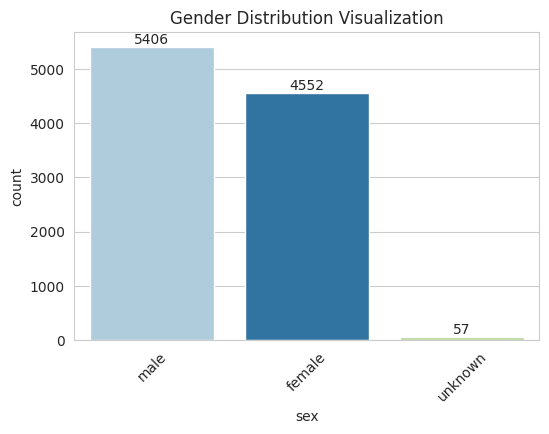

In [ ]:
sns.set_style('whitegrid')
colors = ['#87ace8','#e3784d', 'green']
fig,axes = plt.subplots(figsize=(6,4))

ax = sns.countplot(x='sex', hue='sex', data=df, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Gender Distribution Visualization')
plt.xticks(rotation=45)
plt.show()

*   Cell type affect on Patients



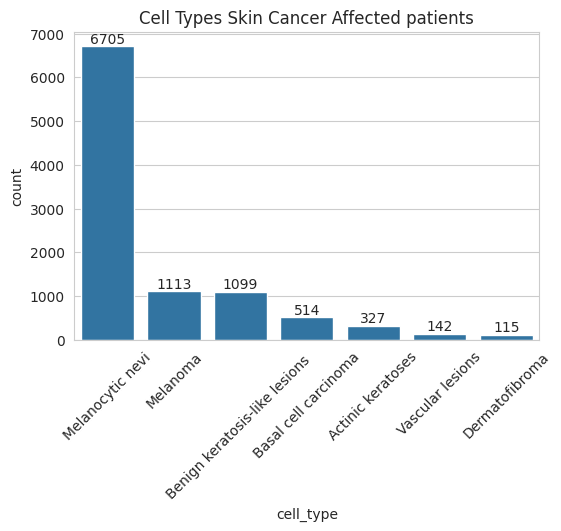

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(6,4))

ax = sns.countplot(
    x='cell_type',
    data=df,
    order = df['cell_type'].value_counts().index
)

for container in ax.containers:
    ax.bar_label(container)

plt.title('Cell Types Skin Cancer Affected patients')
plt.xticks(rotation=45)
plt.show()

*   Gender vs Cell type



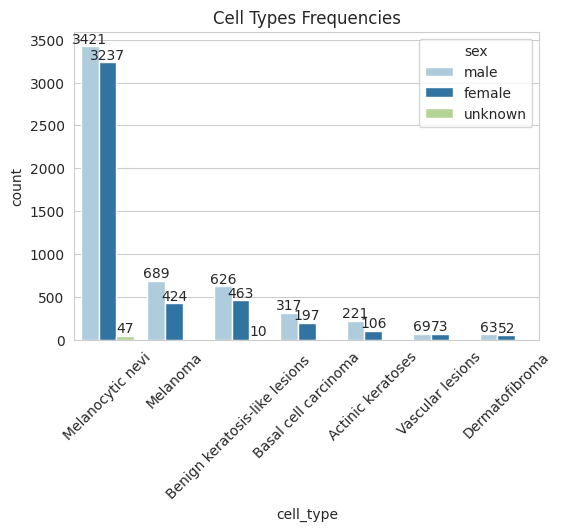

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(6,4))
ax = sns.countplot(
    x='cell_type',
    hue='sex',
    data=df,
    order = df['cell_type'].value_counts().index,
    palette = 'Paired')

for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

* Cell Type

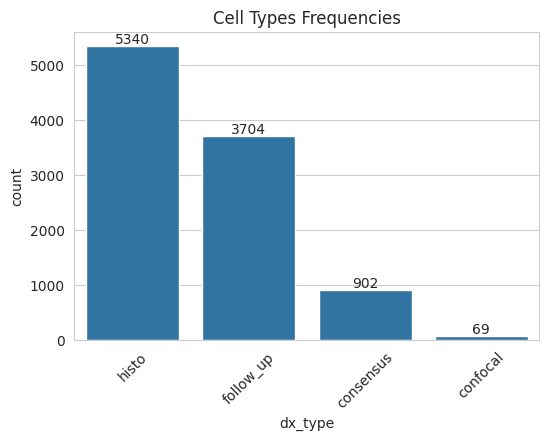

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(6,4))

ax = sns.countplot(
    x='dx_type',
    data=df,
    order = df['dx_type'].value_counts().index)

for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

* Gender wise Cell Type Distribution

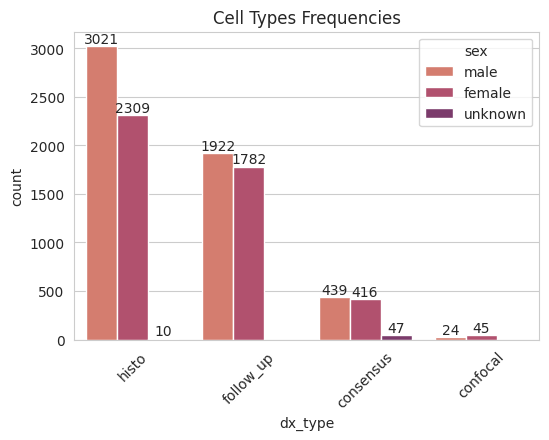

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(6,4))

ax = sns.countplot(
    x='dx_type',
    hue='sex',
    data=df,
    order = df['dx_type'].value_counts().index,
    palette = 'flare')

for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

* Localization area

<ipython-input-45-9812eca0c653>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


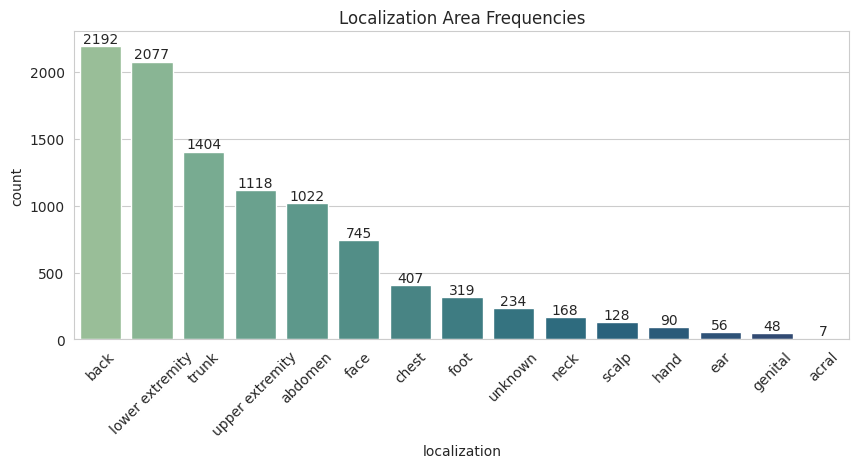

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(10,4))

ax = sns.countplot(
    x='localization',
    #hue = 'localization',
    data=df,
    order = df['localization'].value_counts().index,
    palette = 'crest'
    )
for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

* Genderwise localization areas

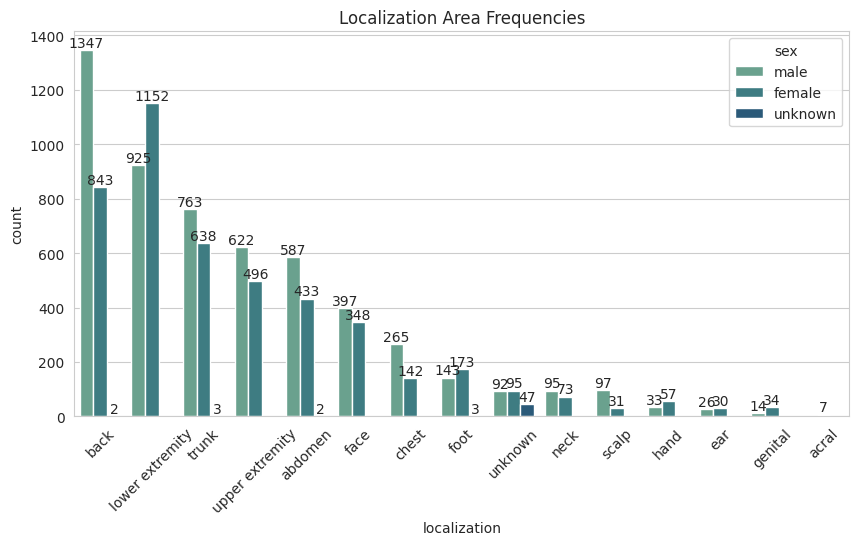

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(10,5))

ax = sns.countplot(
    x='localization',
    hue='sex',
    data=df,
    order = df['localization'].value_counts().index,
    palette = 'crest')

for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

* Age

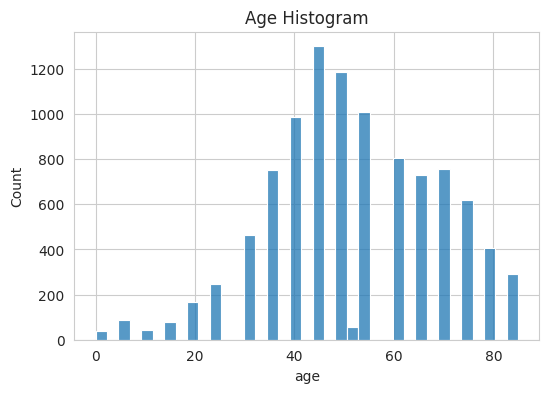

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(6,4))
ax = sns.histplot(data=df, x='age')
plt.title('Age Histogram')
plt.show()

* Gender wise Age distribution

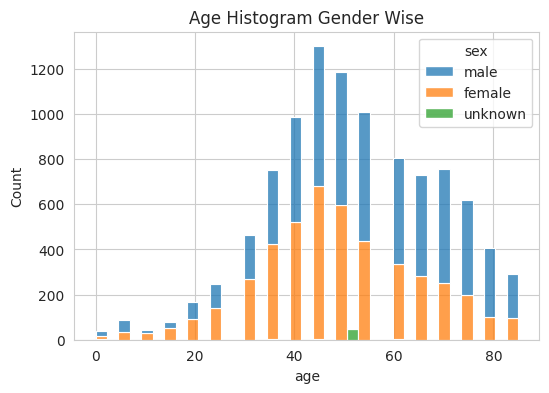

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(6,4))
ax = sns.histplot(data=df, x='age',hue='sex',multiple='stack')
plt.title('Age Histogram Gender Wise')
plt.show()

* Cell Type vs Age

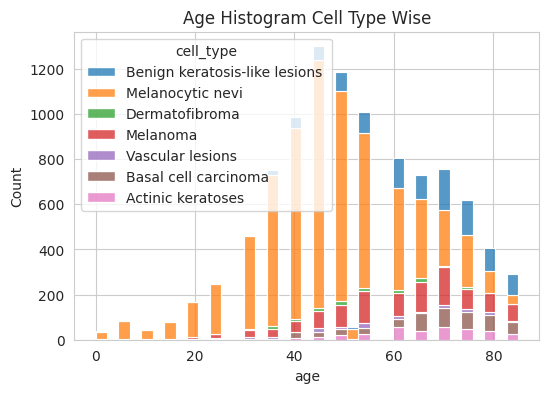

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(6,4))
ax = sns.histplot(data=df, x='age',hue='cell_type',multiple='stack')
plt.title('Age Histogram Cell Type Wise')
plt.show()

* Localization Area vs Age

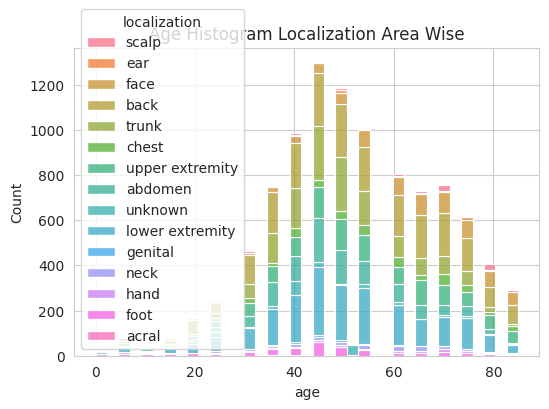

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(6,4))
ax = sns.histplot(data=df, x='age',hue='localization',multiple='stack')
plt.title('Age Histogram Localization Area Wise')
plt.show()

# **Resizing the Image**

In [ ]:
from PIL import Image
import numpy as np

df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

# **Saving the resized images in Google Colab**

In [ ]:
# resize_images.py
# Script pentru redimensionarea și salvarea imaginilor dintr-un DataFrame, cu skip silențios dacă există deja
import os
from PIL import Image
import numpy as np

# Directorul de destinație pentru imaginile redimensionate
output_dir = '/content/drive/MyDrive/resized_images'
os.makedirs(output_dir, exist_ok=True)

# Verificăm dacă există deja fișiere JPEG în output_dir
existing_jpegs = [f for f in os.listdir(output_dir) if f.lower().endswith('.jpg')]

if not existing_jpegs:
    # Presupunem că 'df' are o coloană 'image' cu array-urile de pixeli
    for idx, img_array in enumerate(df['image']):
        img = Image.fromarray(img_array.astype('uint8'))
        fname = f'image_{idx:05d}.jpg'
        img.save(os.path.join(output_dir, fname), format='JPEG', quality=90)
    print(f"Am redimensionat și salvat {len(df)} imagini în '{output_dir}'.")

# **Pictorial representation of Images of dataset**

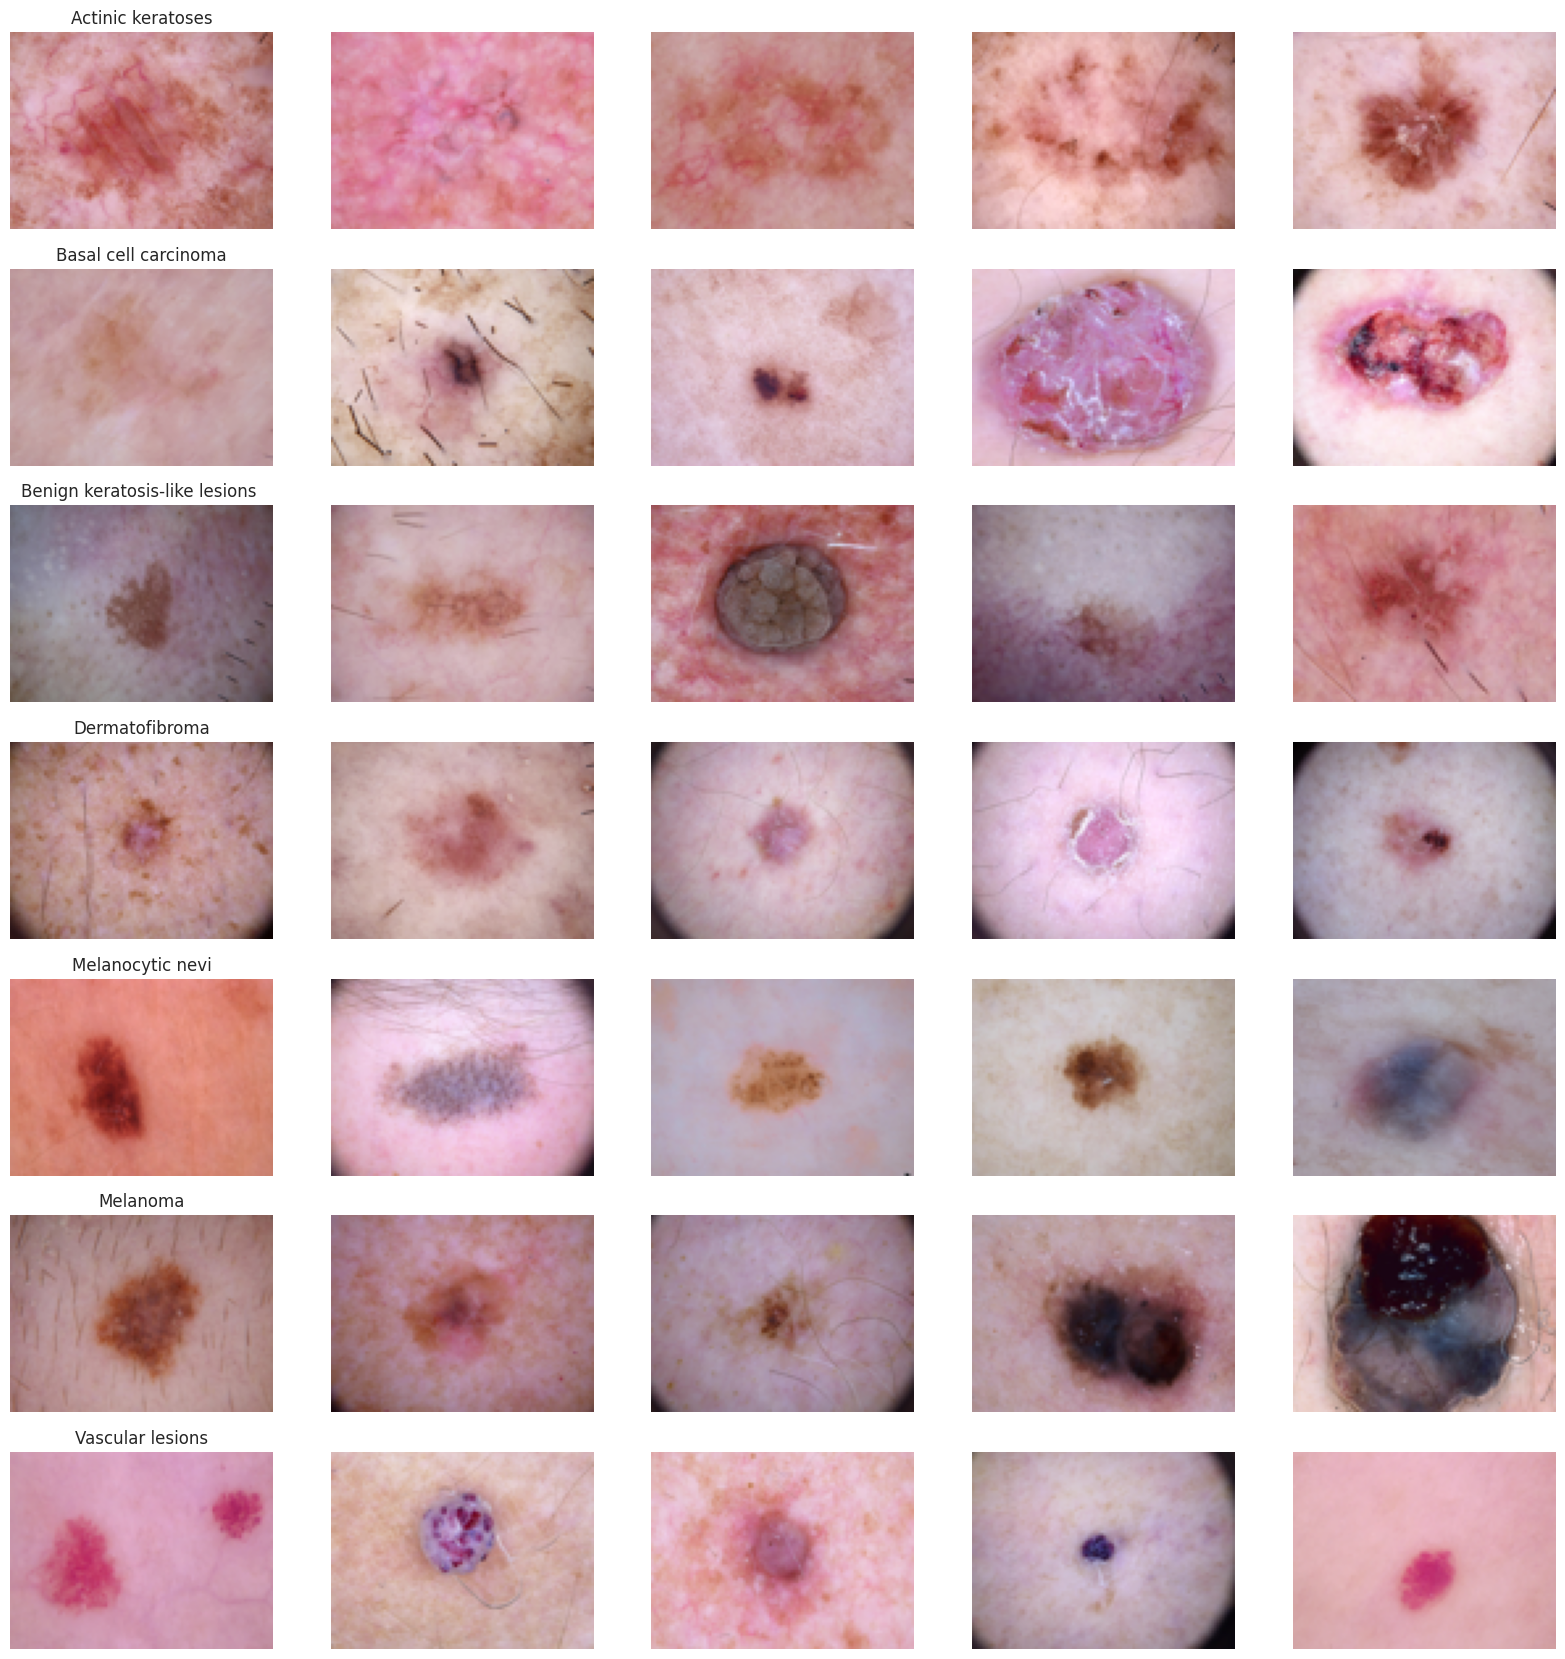

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np

n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

# **Data Modeling**

**Setting target variable**

In [ ]:
features=df.drop(columns=['cell_type_idx'],axis=1)
target=df['cell_type_idx']

**Splitting the Dataset**

In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

**Normalization of images**

In [ ]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

**One hot encoding on labels**

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

**Splitting into training and validation set**

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [ ]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

# **Setting the CNN model**

In [ ]:
from tensorflow.keras.models import Sequential # Importing the Sequential class
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # Importing necessary layers

# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 75, 100, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 100, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,752,999 (14.32 MB)

 Trainable params: 3,752,999 (14.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Define the optimizer using learning_rate instead of lr
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
# Make sure to import ReduceLROnPlateau
from tensorflow.keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', # Change to 'val_accuracy' if needed
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001) # Change learning_rate to min_lr

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


# **Data augmentation to prevent overfitting**

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

# **Fitting the model**

In [ ]:
epochs = 50
batch_size = 10

print("Train:", x_train.shape, y_train.shape)
print("Val:  ", x_validate.shape, y_validate.shape)
steps = x_train.shape[0] // batch_size
print("steps_per_epoch =", steps)

model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',  # sau alt loss potrivit claselor tale
  metrics=['accuracy']
)


history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_validate, y_validate),
    verbose=1,
    callbacks=[learning_rate_reduction]
)



Train: (7210, 75, 100, 3) (7210, 7)
Val:   (802, 75, 100, 3) (802, 7)
steps_per_epoch = 721
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


721/721 ━━━━━━━━━━━━━━━━━━━━ 320s 439ms/step - accuracy: 0.6606 - loss: 1.1031 - val_accuracy: 0.6808 - val_loss: 0.9064 - learning_rate: 0.0010
Epoch 2/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


721/721 ━━━━━━━━━━━━━━━━━━━━ 315s 437ms/step - accuracy: 0.6811 - loss: 0.8974 - val_accuracy: 0.6833 - val_loss: 0.8481 - learning_rate: 0.0010
Epoch 3/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 318s 441ms/step - accuracy: 0.6886 - loss: 0.8776 - val_accuracy: 0.7057 - val_loss: 0.8277 - learning_rate: 0.0010
Epoch 4/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 319s 443ms/step - accuracy: 0.6787 - loss: 0.8663 - val_accuracy: 0.7020 - val_loss: 0.8029 - learning_rate: 0.0010
Epoch 5/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 321s 441ms/step - accuracy: 0.6925 - loss: 0.8431 - val_accuracy: 0.6995 - val_loss: 0.7835 - learning_rate: 0.0010
Epoch 6/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 317s 439ms/step - accuracy: 0.6899 - loss: 0.8286 - val_accuracy: 0.7057 - val_loss: 0.7820 - learning_rate: 0.0010
Epoch 7/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 318s 440ms/step - accuracy: 0.6892 - loss: 0.8186 - val_accuracy: 0.7294 - val_loss: 0.7411 - learning_rate: 0.0010
Epoch 8/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 325s 444ms/step - accuracy: 0.7098 

# **Saving the model**

In [ ]:
#model.save('/content/drive/MyDrive/SavedModel')

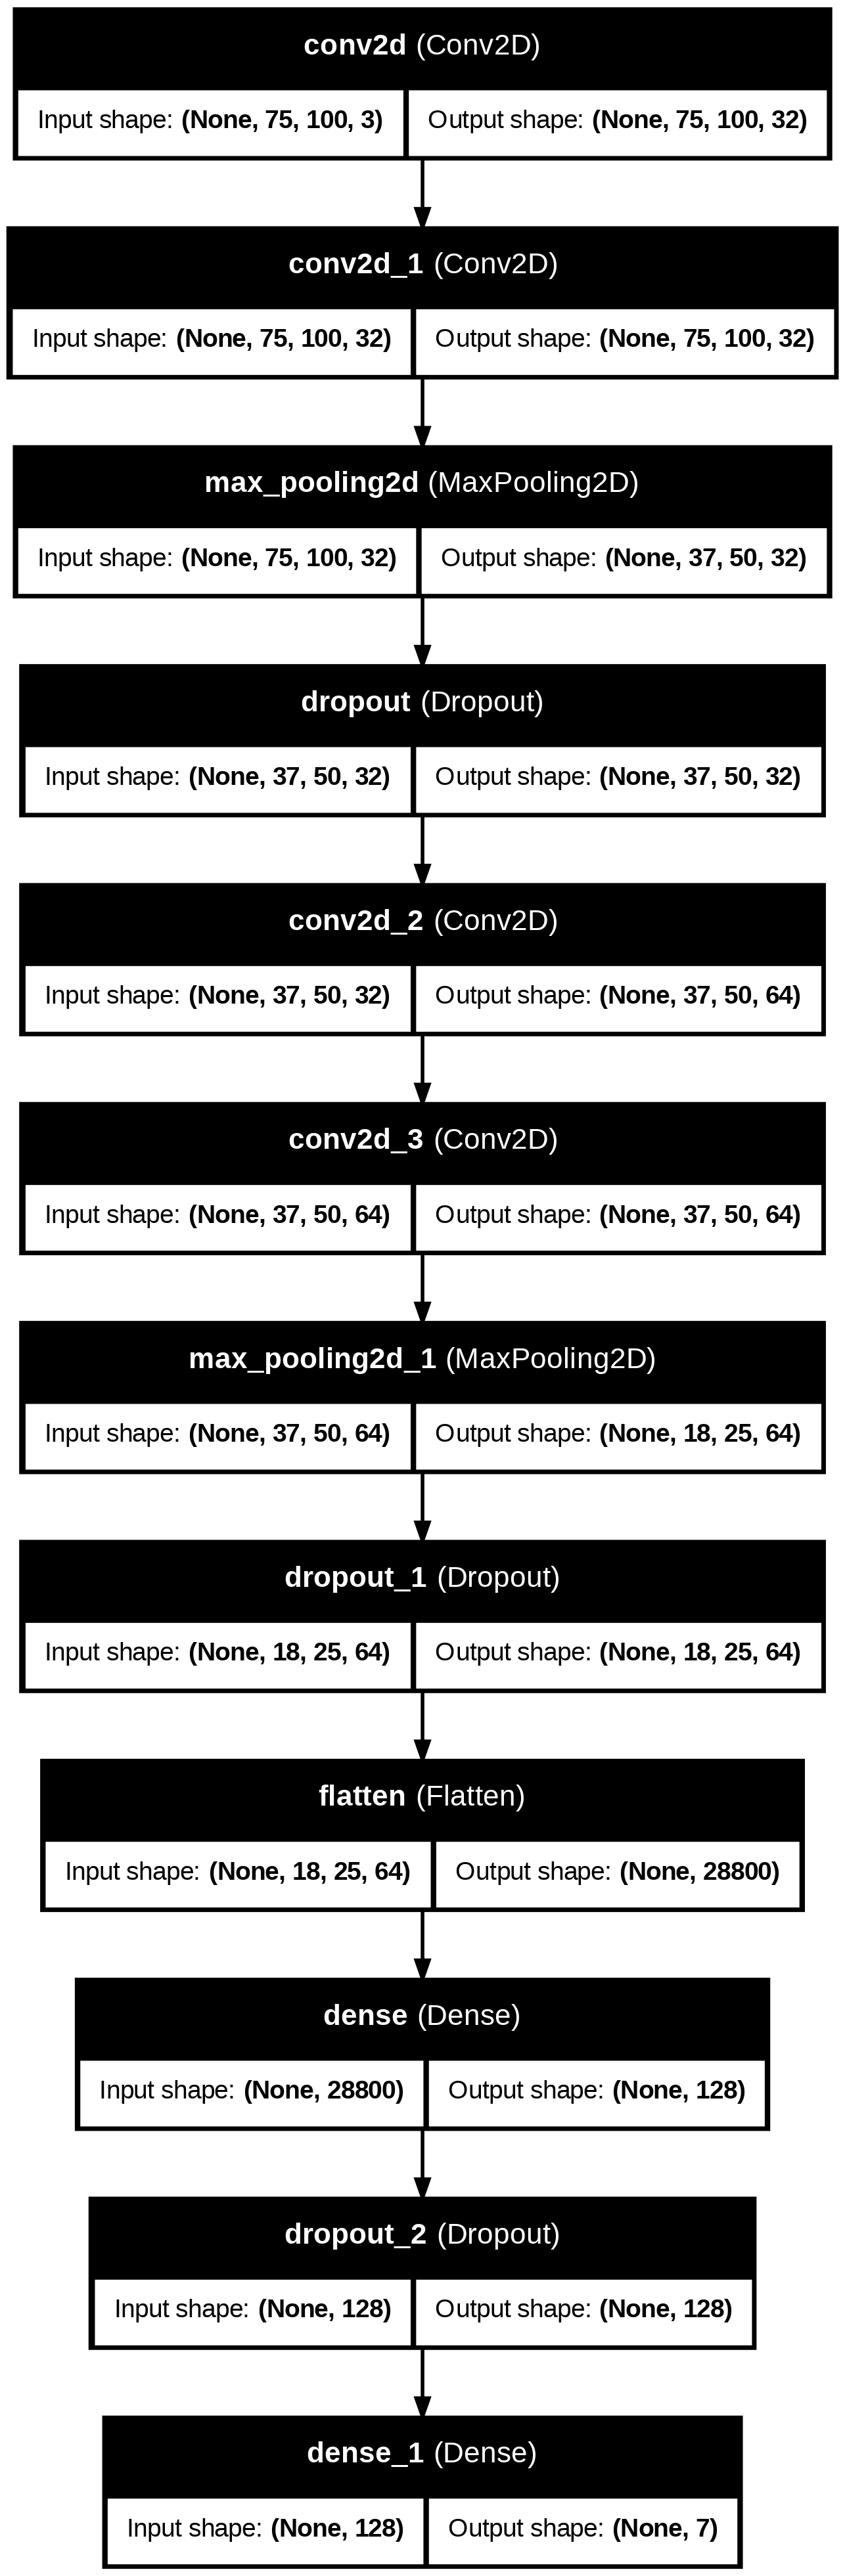

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# **Accuracy of model**

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

 8/63 ━━━━━━━━━━━━━━━━━━━━ 15s 277ms/step - accuracy: 0.7583 - loss: 0.7188

# **Plotting Confusion Matrices**

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report # Import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)


# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

# **Cod de inferență pentru o imagine nouă**

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Dicționar de inversare a indexării claselor
index_to_class = {v: k for k, v in train_flow.class_indices.items()}

def predict_skin_lesion(img_path, model):
    img = image.load_img(img_path, target_size=(75,100))
    x   = image.img_to_array(img) / 255.0
    x   = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    idx   = np.argmax(preds, axis=1)[0]
    label = index_to_class[idx]
    prob  = preds[0, idx]
    return label, prob

# Exemplu de utilizare:
label, confidence = predict_skin_lesion('/mnt/data/Dataset2/ISIC_0024306.jpg', model)
print(f'Predicted: {label} ({confidence*100:.1f}% încredere)')


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Assuming you have 7 classes
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Create the index_to_class mapping based on class names
index_to_class = {i: class_name for i, class_name in enumerate(class_names)}


def predict_skin_lesion(img_path, model):
    img = image.load_img(img_path, target_size=(75, 100))
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    idx = np.argmax(preds, axis=1)[0]
    label = index_to_class[idx]
    prob = preds[0, idx]
    return label, prob

# Exemplu de utilizare:
label, confidence = predict_skin_lesion('/content/drive/MyDrive/SkinCancerDet&Class/Dataset2', model)
print(f'Predicted: {label} ({confidence * 100:.1f}% încredere)')